<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Set-Parameters" data-toc-modified-id="Set-Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set Parameters</a></span></li><li><span><a href="#Prepare-Random-Data" data-toc-modified-id="Prepare-Random-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Random Data</a></span></li><li><span><a href="#Prepare-DataFrame-to-Record-Simulation-Results" data-toc-modified-id="Prepare-DataFrame-to-Record-Simulation-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare DataFrame to Record Simulation Results</a></span></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run Simulation</a></span></li><li><span><a href="#Fill-In-Derived-Data" data-toc-modified-id="Fill-In-Derived-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fill-In Derived Data</a></span></li><li><span><a href="#Analyse-Results-of-this-Simulation-Run" data-toc-modified-id="Analyse-Results-of-this-Simulation-Run-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analyse Results of this Simulation Run</a></span></li><li><span><a href="#Run-Simulation-Study" data-toc-modified-id="Run-Simulation-Study-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Run Simulation Study</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Load Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import simpy

# Set Parameters

In [2]:
INTERVAL_CUSTOMERS=5 # average time between events
PROCESSING_TIME=4  # average processing time in the bank
CUSTOMERS=10 # number of customers 

# Prepare Random Data

In [3]:
random.seed(42)

In [4]:
# Create a DataFrame with input parameters
cdata = pd.DataFrame()
cdata['arr'] = [ random.expovariate(1.0/INTERVAL_CUSTOMERS) for i in range(CUSTOMERS) ]
cdata['proc'] = [ random.expovariate(1.0/PROCESSING_TIME) for i in range(CUSTOMERS) ]

In [5]:
cdata.head()

,arr,proc
0,5.100301,0.986867
1,0.126644,2.815662
2,1.608120,0.107578
3,1.262931,0.886767
4,6.667963,4.197968


In [6]:
cdata.describe()

,arr,proc
count,10.000000,10.000000
mean,3.489451,2.335653
std,3.598516,2.116568
min,0.126644,0.026080
25%,0.656804,0.911792
50%,2.174176,1.905884
75%,5.509474,3.456755
max,11.136440,6.630952


In [7]:
def poissonPlot(data, title=None):
    μ = data.mean()
    n = data.count()
    max = math.ceil(data.max()/10)*10
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax = fig.gca()
    ax.set_xlim(0, max)
    
    if title!=None:
        ax.set_title(title+" (n={:,})".format(n))
        
    data.hist(ax=ax, bins=max+1, density=True)

    x = [ i/10 for i in range(1, 10*max)]
    y = [ 1/μ*math.exp(-x/μ) for x in x]
    plt.plot(x, y, lw=3, color='red')
    ax.axvline(x=μ, color='red')
    plt.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=14)
    plt.grid(True)

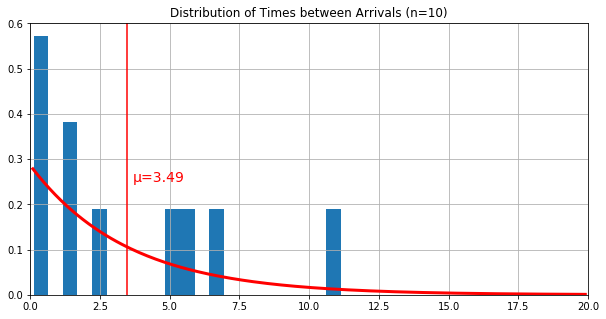

In [8]:
poissonPlot(cdata['arr'], title="Distribution of Times between Arrivals")

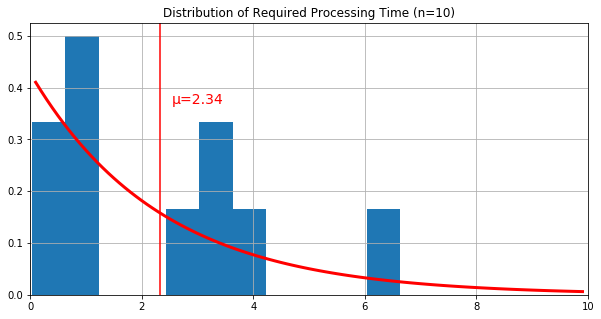

In [9]:
poissonPlot(cdata['proc'], title="Distribution of Required Processing Time")

# Prepare DataFrame to Record Simulation Results

In [10]:
# Prepare a DataFrame to record observations
sdata = pd.DataFrame()
sdata['arrived at'] = [None]*CUSTOMERS
sdata['proc started at'] = [None]*CUSTOMERS
sdata['proc finished at'] = [None]*CUSTOMERS 

In [11]:
sdata.head()

,arrived at,proc started at,proc finished at
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None


# Run Simulation

Doc [simpy](https://simpy.readthedocs.io/en/latest/)

In [12]:
def source(env, n, counter):
    for i in range(n):
        t = cdata.at[i, 'arr']
        # wait until the next customer arrives...
        yield env.timeout(t)
        c = customer(env, i, counter)
        env.process(c)

In [13]:
def customer(env, i, counter):
    sdata.at[i, 'arrived at'] = env.now
    print(f"customer {i:d} arrives at  {env.now:6.2f}")
    
    req = counter.request()
        
    # Wait for the counter 
    yield req 

    print(f"serving customer {i:d} at  {env.now:6.2f}")
    sdata.at[i, 'proc started at'] = env.now
    
    yield env.timeout(cdata.at[i, 'proc'])
    
    sdata.at[i, 'proc finished at'] = env.now
    print(f"finished customer {i:d} at {env.now:6.2f}")
    
    counter.release(req)


In [14]:
len(cdata)

10

In [15]:
env = simpy.Environment()
counter = simpy.Resource(env, capacity=1)
env.process(source(env, CUSTOMERS, counter))
env.run()

customer 0 arrives at    5.10
serving customer 0 at    5.10
customer 1 arrives at    5.23
finished customer 0 at   6.09
serving customer 1 at    6.09
customer 2 arrives at    6.84
customer 3 arrives at    8.10
finished customer 1 at   8.90
serving customer 2 at    8.90
finished customer 2 at   9.01
serving customer 3 at    9.01
finished customer 3 at   9.90
customer 4 arrives at   14.77
serving customer 4 at   14.77
finished customer 4 at  18.96
customer 5 arrives at   20.41
serving customer 5 at   20.41
finished customer 5 at  23.56
customer 6 arrives at   31.55
serving customer 6 at   31.55
customer 7 arrives at   32.00
finished customer 6 at  32.54
serving customer 7 at   32.54
customer 8 arrives at   34.74
customer 9 arrives at   34.89
finished customer 7 at  36.10
serving customer 8 at   36.10
finished customer 8 at  42.73
serving customer 9 at   42.73
finished customer 9 at  42.76


In [16]:
sdata.head(10)

,arrived at,proc started at,proc finished at
0,5.1003,5.1003,6.08717
1,5.22695,6.08717,8.90283
2,6.83507,8.90283,9.01041
3,8.098,9.01041,9.89717
4,14.766,14.766,18.9639
5,20.4118,20.4118,23.5611
6,31.5483,31.5483,32.5444
7,32.003,32.5444,36.1036
8,34.7433,36.1036,42.7346
9,34.8945,42.7346,42.7606


# Fill-In Derived Data

In [17]:
sdata['wait time']=sdata['proc started at']-sdata['arrived at'] 
sdata['proc time']=sdata['proc finished at']-sdata['proc started at']
sdata['idle time']=sdata['proc started at']-sdata['proc finished at'].shift(1)
sdata.at[0, 'idle time']=sdata.at[0, 'proc started at']

In [18]:
sdata.head(10)

,arrived at,proc started at,proc finished at,wait time,proc time,idle time
0,5.1003,5.1003,6.08717,0,0.986867,5.1003
1,5.22695,6.08717,8.90283,0.860223,2.81566,0
2,6.83507,8.90283,9.01041,2.06776,0.107578,0
3,8.098,9.01041,9.89717,0.912411,0.886767,0
4,14.766,14.766,18.9639,0,4.19797,4.86879
5,20.4118,20.4118,23.5611,0,3.14932,1.4479
6,31.5483,31.5483,32.5444,0,0.996106,7.98712
7,32.003,32.5444,36.1036,0.541344,3.55923,0
8,34.7433,36.1036,42.7346,1.36035,6.63095,0
9,34.8945,42.7346,42.7606,7.84005,0.0260799,0


# Analyse Results of this Simulation Run

In [19]:
w = sdata['wait time']
print(f"Customers waited in average  {w.mean():5.2f}min.")
print(f"The minimum waiting time was {w.min():5.2f}min.")
print(f"the maximum waiting time was {w.max():5.2f}min.")

Customers waited in average   1.36min.
The minimum waiting time was  0.00min.
the maximum waiting time was  7.84min.


In [20]:
proc_time=sdata['proc time'].sum()
idle_time=sdata['idle time'].sum()
total_time=proc_time+idle_time
print(f"Server utilisation was {100*proc_time/total_time:4.1f}% "
      f"over a total time of {total_time/60:4.1f} hours")

Server utilisation was 54.6% over a total time of  0.7 hours


# Run Simulation Study

In [21]:
def MM1(IARR, PROC, N, log=False, plot=False):
    cd = pd.DataFrame()
    cd['iarr'] = [ random.expovariate(1.0/IARR) for i in range(N) ]
    cd['proc'] = [ random.expovariate(1.0/PROC) for i in range(N) ]
    # Prepare a DataFrame to record observations
    sd = pd.DataFrame()
    sd['arrived at'] = [None]*N
    sd['proc started at'] = [None]*N
    sd['proc finished at'] = [None]*N 
    
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=1)
    
    # initialise variables describing the queue
    maxql=0  # maximum length of queue
    qt=0     # "integral" of ql from 0 to lastT
    lastT=0 # last time qt was updated
    
    # initialise variables describing the server
    maxs=0   # max number of customers served at anyone time
    s=0      # current number of customers being served
    st=0     # "integral" of s from 0 to env.now
    
    def source(n):
        # generate the customers.
        for i in range(n):
            # wait until the next customer arrives...
            yield env.timeout(cd.at[i, 'iarr'])
            c = customer(i)
            env.process(c)
     
    def customer(i):
        sd.at[i, 'arrived at'] = env.now
        
        nonlocal qt, lastT, maxql, s, st, maxs
        
        # length of the queue before the customer enters

        ql = len(counter.queue) 
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        if ql==maxql:
            maxql = ql+1

        req = counter.request()
        # Wait for the counter 
        
        yield req
        
        # length of the queue just before the customer leaves
        ql = len(counter.queue)+1 
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        sd.at[i, 'proc started at'] = env.now
        # Wait while the clerk is dealing with you
        
        s += 1
        if s>maxs:
            maxs = s
            
        proc = cd.at[i, 'proc']
        yield env.timeout(proc)
        sd.at[i, 'proc finished at'] = env.now
        counter.release(req)
        
        s -= 1
        st += proc
        
            
    env.process(source(N))
    env.run()
    
    sd['wait time']=sd['proc started at']-sd['arrived at'] 
    sd['proc time']=sd['proc finished at']-sd['proc started at']
    sd['flow time']=sd['proc finished at']-sd['arrived at']
    
    sd['idle time']=sd['proc started at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idle time']=sd.at[0, 'proc started at']
    
    sd['idep']=sd['proc finished at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idep']=sd.at[0, 'proc finished at']
    
    w = sd['wait time']
    f = sd['flow time']
    
    if plot:
        poissonPlot(cd['iarr'], "Inter-Arrival Times")
        poissonPlot(cd['proc'], "Processing Times")
        poissonPlot(sd['wait time'], "Wait Times")
        poissonPlot(sd['flow time'], "Flow Times")
        poissonPlot(sd['idep'], "Inter-Departure Times")
        
        
    if log:
        μ_iarr = cd['iarr'].mean()
        μ_proc = cd['proc'].mean()
        ρ = st/lastT
        ρ_theor = PROC/IARR
        Lq = qt/lastT
  
        print("   actual / expected")
        print(f"a= {μ_iarr:6.2f}   {IARR:6.2f}   (Inter Arrival Time)")
        print(f"p= {μ_proc:6.2f}   {PROC:6.2f}   (Processing Time)")
        print(f"ρ= {100*ρ:5.1f}%  {100*ρ_theor:6.1f}%   (System Utilisation)")
        print(f"L= {ρ+Lq:6.2f}   {ρ_theor/(1-ρ_theor):6.2f}   (inventory in the system)")
        print(f"Lq={Lq:6.2f}   {ρ_theor**2/(1-ρ_theor):6.2f}   (inventory in the queue)")
        print(f"Ls={ρ:6.2f}   {ρ_theor:6.2f}   (inventory in service)")
        print(f"W= {f.mean():6.2f}   {PROC/(1-ρ_theor):6.2f}   (Flow Time through the System")
        print(f"Wq={w.mean():6.2f}   {PROC*ρ_theor/(1-ρ_theor):6.2f}   (Wait Time)")
        print(f"Ws={μ_proc:6.2f}   {PROC:6.2f}   (Service Time)")
        print()
        
    return w.mean(), w.max(), qt/lastT, maxql, st/lastT

In [22]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(5,4,10, log=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   3.49     5.00   (Inter Arrival Time)
p=   2.34     4.00   (Processing Time)
ρ=  54.7%    80.0%   (System Utilisation)
L=   0.86     4.00   (inventory in the system)
Lq=  0.32     3.20   (inventory in the queue)
Ls=  0.55     0.80   (inventory in service)
W=   3.69    20.00   (Flow Time through the System
Wq=  1.36    16.00   (Wait Time)
Ws=  2.34     4.00   (Service Time)

Max Wq=  7.84  
Max Lq=  2  


   actual / expected
a=   4.22     4.00   (Inter Arrival Time)
p=   2.93     3.00   (Processing Time)
ρ=  69.5%    75.0%   (System Utilisation)
L=   2.22     3.00   (inventory in the system)
Lq=  1.53     2.25   (inventory in the queue)
Ls=  0.69     0.75   (inventory in service)
W=   9.39    12.00   (Flow Time through the System
Wq=  6.46     9.00   (Wait Time)
Ws=  2.93     3.00   (Service Time)

Max Wq= 55.26  
Max Lq= 18  


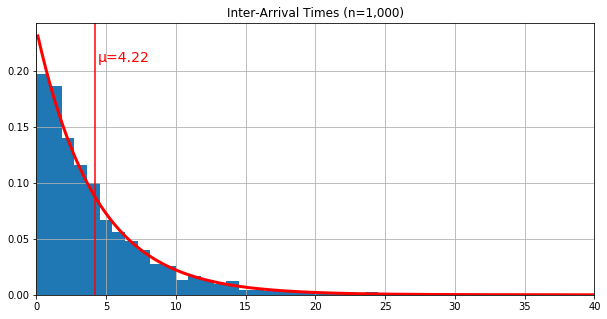

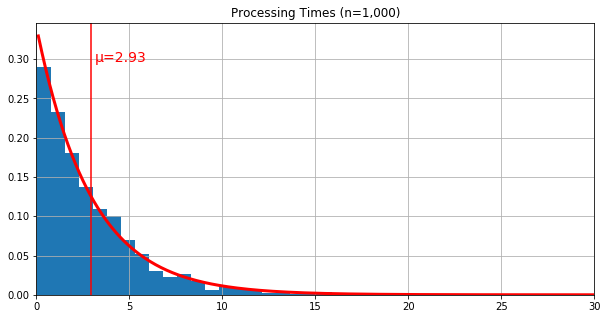

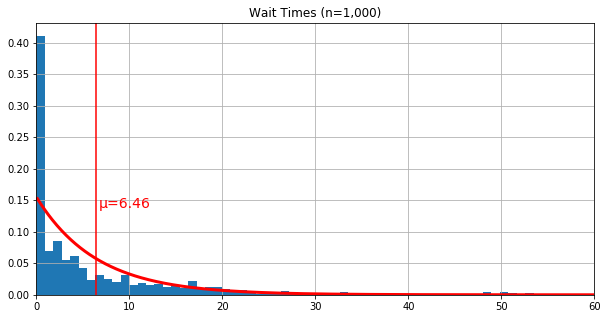

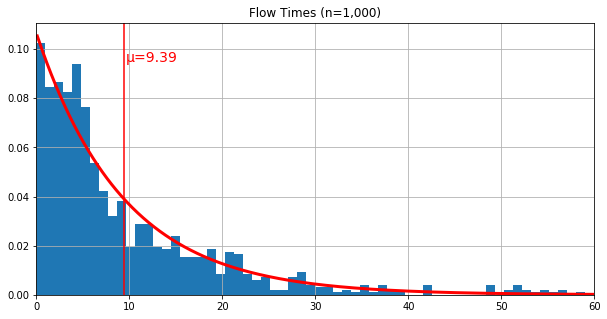

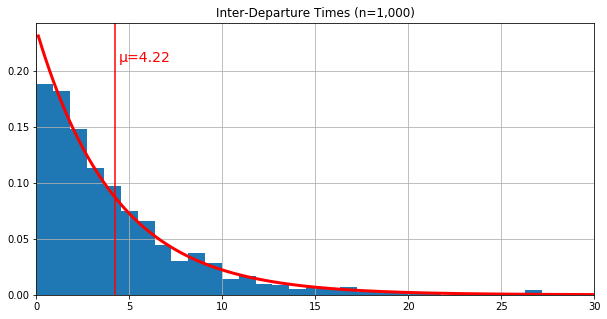

In [23]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,1000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   4.00     4.00   (Inter Arrival Time)
p=   3.02     3.00   (Processing Time)
ρ=  75.5%    75.0%   (System Utilisation)
L=   3.06     3.00   (inventory in the system)
Lq=  2.31     2.25   (inventory in the queue)
Ls=  0.75     0.75   (inventory in service)
W=  12.25    12.00   (Flow Time through the System
Wq=  9.23     9.00   (Wait Time)
Ws=  3.02     3.00   (Service Time)

Max Wq= 91.94  
Max Lq= 23  


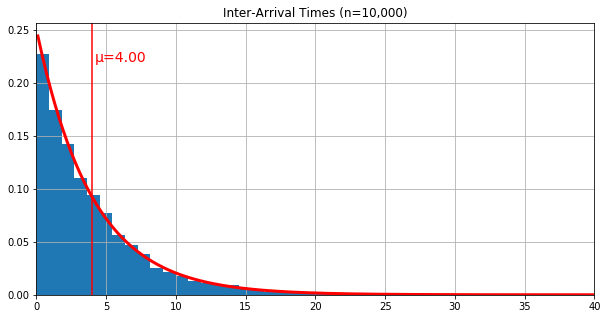

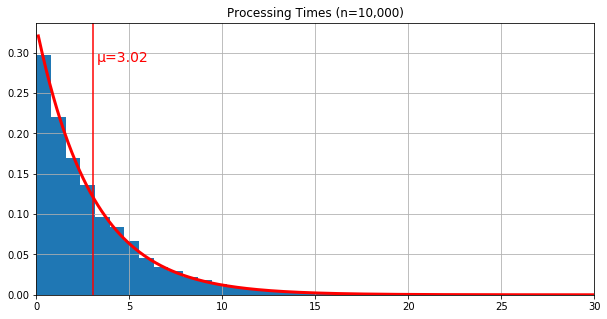

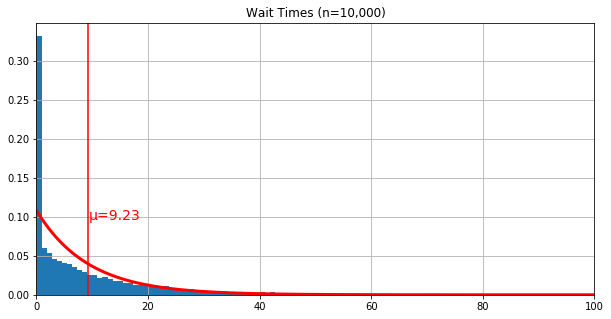

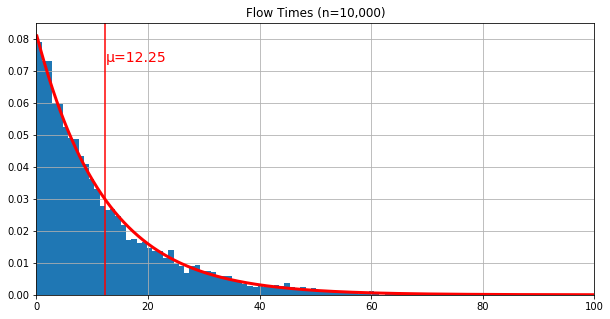

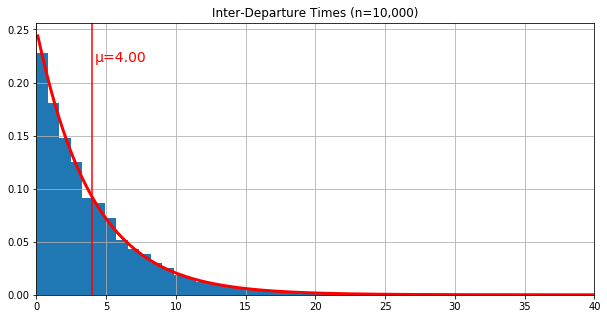

In [24]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,10000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   4.01     4.00   (Inter Arrival Time)
p=   3.01     3.00   (Processing Time)
ρ=  75.1%    75.0%   (System Utilisation)
L=   2.99     3.00   (inventory in the system)
Lq=  2.24     2.25   (inventory in the queue)
Ls=  0.75     0.75   (inventory in service)
W=  11.98    12.00   (Flow Time through the System
Wq=  8.97     9.00   (Wait Time)
Ws=  3.01     3.00   (Service Time)

Max Wq=107.27  
Max Lq= 33  


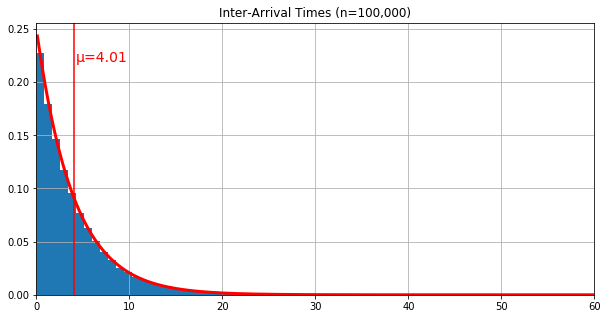

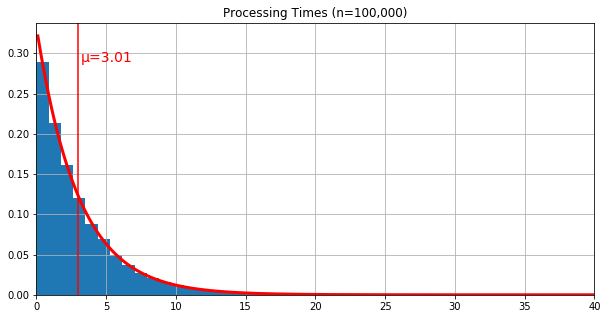

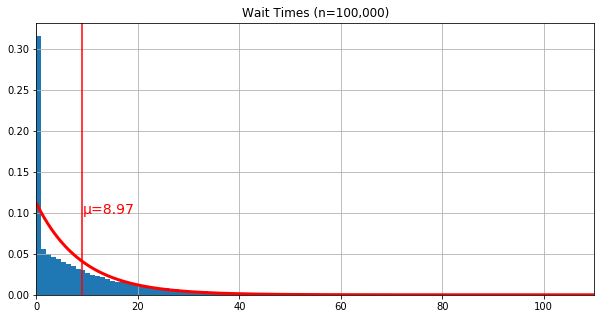

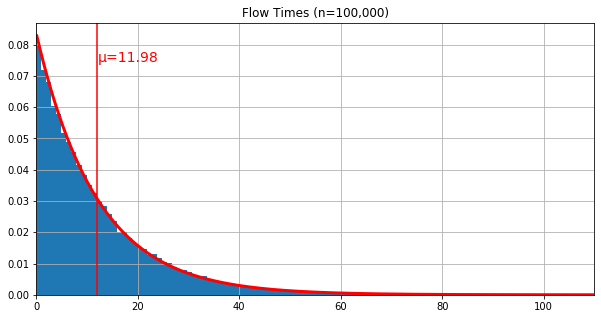

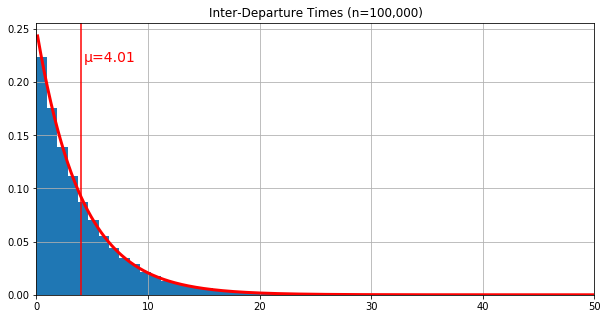

In [25]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MM1(4,3,100000, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

# References

- [python math library]( https://docs.python.org/3/library/math.html)
- [matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/)
- [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [simpy](https://simpy.readthedocs.io/en/latest/contents.html) 
    [.pdf](https://readthedocs.org/projects/simpy/downloads/pdf/latest/)
    [The In-Depth Manual (2.2)](https://pythonhosted.org/SimPy/Manuals/Manual.html)